In [1]:
# Necessary imports
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [2]:
# Modules for defining networks
from torch import nn, optim
import torch.nn.functional as F

In [3]:
# Defining Classifier
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)

        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))

        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

In [4]:
model = Classifier()

criterion = nn.NLLLoss() # Negative logarithmic Loss calculated

optimizer = optim.Adam(model.parameters(), lr=0.003) # Optimizer

epochs = 10 # Passing the model '10' times through the network
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                
                # If the labels and the highest scores (or) probabilities are equal , the the model is accurate.
                
                top_p, top_class = ps.topk(1, dim=1) # Returns the top probability with the indices.
                equals = top_class == labels.view(*top_class.shape) # Converting to 1d vector
                accuracy += torch.mean(equals.type(torch.FloatTensor)) # Converting Byte Tensor to Float Tensor for calc. Mean
        
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_losses[-1]),
              "Test Loss: {:.3f}.. ".format(test_losses[-1]),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/10..  Training Loss: 0.607..  Test Loss: 0.483..  Test Accuracy: 0.823
Epoch: 2/10..  Training Loss: 0.485..  Test Loss: 0.417..  Test Accuracy: 0.846
Epoch: 3/10..  Training Loss: 0.450..  Test Loss: 0.456..  Test Accuracy: 0.833
Epoch: 4/10..  Training Loss: 0.432..  Test Loss: 0.415..  Test Accuracy: 0.851
Epoch: 5/10..  Training Loss: 0.420..  Test Loss: 0.419..  Test Accuracy: 0.851
Epoch: 6/10..  Training Loss: 0.417..  Test Loss: 0.413..  Test Accuracy: 0.855
Epoch: 7/10..  Training Loss: 0.408..  Test Loss: 0.389..  Test Accuracy: 0.859
Epoch: 8/10..  Training Loss: 0.399..  Test Loss: 0.382..  Test Accuracy: 0.865
Epoch: 9/10..  Training Loss: 0.393..  Test Loss: 0.393..  Test Accuracy: 0.861
Epoch: 10/10..  Training Loss: 0.392..  Test Loss: 0.385..  Test Accuracy: 0.867


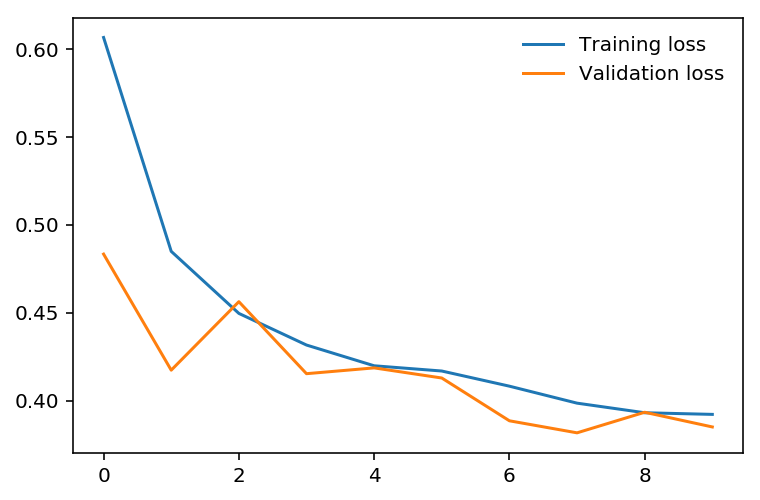

In [5]:
# Plotting the losses. Note the fall in the losses.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

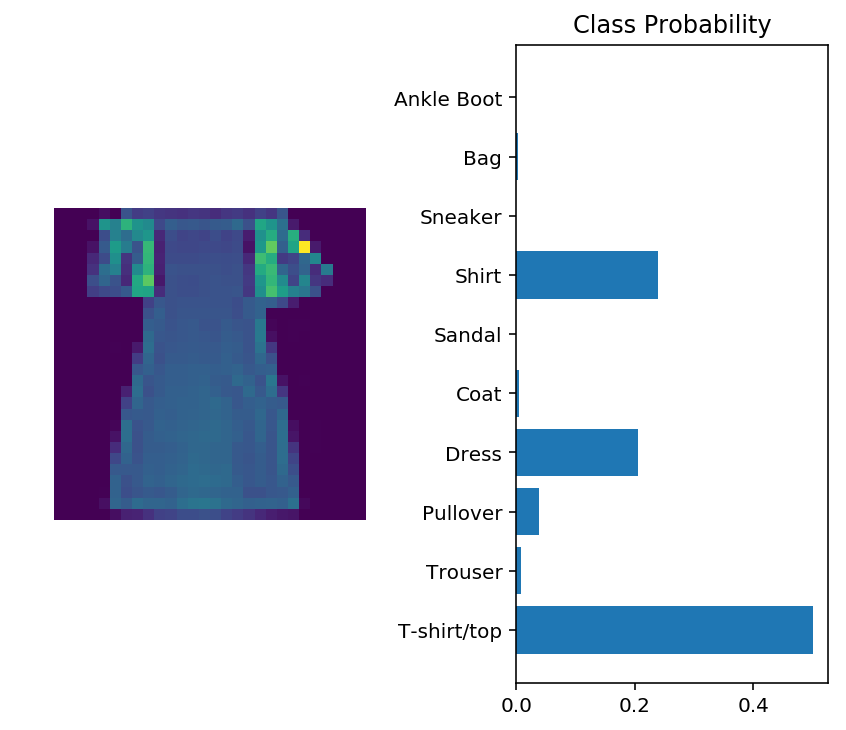

In [7]:
import numpy as np
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]

# Convert 2D image to 1D vector
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
    output = model.forward(img)

ps = torch.exp(output)

# Plotting this data by converting the tensor back to numpy array
ps = ps.data.numpy().squeeze()
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), ps)
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']);
ax2.set_title('Class Probability')
plt.tight_layout()

# Show the plot
plt.show()